In [6]:
# Setup Keys
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
import langchain
print(langchain.__version__)

1.2.10


# EssayMaker (Baseline - No Memory)

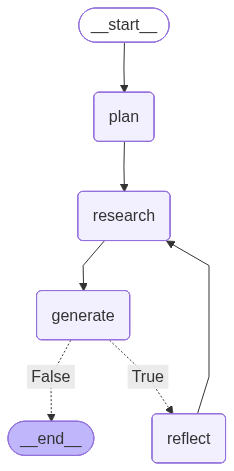

In [26]:
from IPython.display import Image, display
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.types import interrupt, Command
from typing import TypedDict, Annotated, List
from langchain_community.tools.tavily_search import TavilySearchResults
import re
import ast
import json
from pprint import pprint
from IPython.display import HTML, display
import html as html_lib

# Utility function
def extract_dict_from_string(text: str) -> dict:
    """
    Extract and convert a dictionary from a string that may contain extra text.
    Tries JSON first, then falls back to ast.literal_eval.
    """
    # Strip markdown code fences if present
    cleaned = text.strip()

    if re.search(r'```json', cleaned):
      list_substr = cleaned.split("```json")
      cleaned = list_substr[1]
    if re.search(r'```', cleaned):
      list_substr = cleaned.split("```")
      cleaned = list_substr[0]

    cleaned = cleaned.strip()

    try:
        result = json.loads(cleaned)
        if isinstance(result, dict):
            return result
    except json.JSONDecodeError:
        pass

    print(f"❌ Failed to extract dict from response:\n{text[:200]}")
    return {}

# Build tool
baseline_search_tool = TavilySearchResults(max_results=5)

# Setup prompt for each task
BASELINE_PROMPT_PLAN = """
  You are an expert essay planner. Your job is to create a detailed and well-structured outline for an essay that will be no longer than 5 paragraphs

  Given the topic and requirements from the user, you must produce an outline that includes:
  1. A strong thesis statement
  2. An introduction section with a hook and context
  3. 3-5 main body sections, each with:
    - A clear section title
    - 2-3 key points to cover
    - A brief description of what each point should address
  4. A conclusion section that ties everything together

  Guidelines:
  - The outline should be logical and flow naturally from one section to the next
  - Each section should build upon the previous one
  - Make sure the outline directly addresses the user's requirements
  - Tailor the depth and complexity to match the required essay length and academic level

  User Input:
  {user_input}

  Agent Output in JSON Format where "" represent the keys :
  - "requirement", derrived from user input
  - "outline", the outline produced by the agent based on the prompt
  - "max_revisions", the maximum revision of the draft essay based on the user input, if it's not specified by the user return 0
  - "max_web_search", the maximum web search that can be done by the agent based on the user input, if it's not specified by the user return 0
"""

BASELINE_PROMPT_RESEARCH = """
  You are an expert research assistant. Your job is to gather relevant information and sources to support an essay based on a given outline.
  If the feedback is not empty, focus on doing search to help gain information to assess the feedback
  You can do up to {max_web_search} searches.

  For each section and key point in the outline, you must:
  1. Search the web for credible and relevant information
  2. Extract key facts, statistics, quotes, or arguments that support the point
  3. Note the source URL and title for citation purposes
  4. Prioritize recent and authoritative sources (academic journals, reputable news, official reports)

  Guidelines:
  - Search for each main section and key point separately to ensure thorough coverage
  - If a search does not return useful results, try rephrasing the query
  - Avoid using low-quality or unreliable sources (forums, opinion blogs without credentials)
  - Collect at least 2-3 supporting pieces of information per key point
  - Organize the collected information according to the outline structure

  Essay Outline:
  {outline}

  Feedback:
  {feedback}

  Agent Output in JSON Format where "" represent the keys :
  - "research", that containsFor each section in the outline, provide with this format
    - Section title
    - Key Point
      - Supporting fact/quote/argument
      - Source: [title] (URL)
"""

BASELINE_PROMPT_GENERATE = """
  You are an expert essay writer. Your job is to write a well-structured, coherent, and polished essay based on the provided outline and research materials.

  Guidelines:
  - Follow the outline structure closely
  - Integrate the research findings naturally into the essay — do not simply list facts
  - Write in a clear, engaging, and appropriate academic tone
  - Each paragraph should have a clear topic sentence and flow logically
  - Use transitions between sections to maintain coherence
  - Support claims with evidence from the research materials
  - Include proper in-text citations where relevant (e.g., "According to [Source], ...")
  - Match the tone and complexity to the user's original requirements
  - Do NOT make up facts or statistics that are not in the provided research

  Essay Outline:
  {outline}

  Research Materials:
  {research}

  User Requirements:
  {requirement}

  Agent Output in JSON Format where "" represent the keys :
  - "essay", Write the full essay from introduction to conclusion.
"""

BASELINE_PROMPT_REFLECT = """
You are an expert essay editor and evaluator. Your job is to critically evaluate an essay and provide detailed, constructive feedback.

Evaluate the essay based on the following criteria:
1. Structure & Organization
   - Does the essay follow a logical flow?
   - Are transitions between sections smooth?
   - Is the outline structure well executed?

2. Thesis & Argumentation
   - Is the thesis clear and strong?
   - Does the essay consistently support the thesis?
   - Are arguments well-developed and convincing?

3. Evidence & Support
   - Is the essay well-supported with evidence?
   - Are sources credible and properly referenced?
   - Are facts and statistics used effectively?

4. Writing Quality
   - Is the tone appropriate and consistent?
   - Is the writing clear and concise?
   - Are there any grammatical or spelling errors?

5. Alignment with Requirements
   - Does the essay meet all of the user's original requirements?
   - Is the length and depth appropriate?
   - Is the target audience addressed correctly?

Essay to Evaluate:
{essay}

User's Original Requirements:
{requirement}

Agent Output in JSON Format where "" represent the keys :
- "score", give the rating from the scale of 0-10, integer only
- "feedback", the detailed evaluation along with the revision priorities
- "need_to_revised", based on the assessment of the agent return only yes/no where yes mean the draft need to be revised, make sure that it's aligned with the 'score'
"""

PROMPT_HTML = """
  Please help change this text to HTML mode, highlight the key point from the text with bold and red pastel color
  Strictly simply used the content of the text, don't add the content, but make the HTML professional with white background

  Text : {text}
"""

# Agent state
class BaselineAgentState(TypedDict):
    task: str
    requirement: str
    outline: str
    research: str
    essay: str
    feedback: str
    score: int
    need_to_revised: str
    content: List[str]
    revision_number: int

    # user input
    max_revisions: int
    max_web_search: int

# Build model with LangGraph
class BaselineEssayWriterAgent:
    def __init__(self, tools, max_revision:int = 3):
        self.config = {'configurable': {'thread_id': 201}}
        self.max_revision = max_revision
        self.checkpointer = InMemorySaver()

        # Store tools as dictionary
        self.tools = {t.name: t for t in tools}

        # create LLM with tool binding
        self.llm = init_chat_model(
            model="claude-haiku-4-5-20251001",
            temperature=0.5,
        )

        # Bind tools to the model
        self.llm_with_tools = self.llm.bind_tools(tools)

        # to initiate the Graph
        self.graph = StateGraph(BaselineAgentState)
        self.graph.add_node('plan', self.call_agent_plan)
        self.graph.add_node('research', self.call_agent_research)
        self.graph.add_edge('plan', 'research')
        self.graph.add_node('generate', self.call_agent_generate)
        self.graph.add_edge('research', 'generate')
        self.graph.add_conditional_edges(
            'generate',
            self.check_revision_iteration,
            {True: 'reflect', False: END})
        self.graph.add_node('reflect', self.call_agent_reflect)
        self.graph.add_edge('reflect', 'research')
        self.graph.set_entry_point('plan')

        self.graph_np = self.graph.compile(
            checkpointer=self.checkpointer,
            )

    def _update_state(self, new_dict:dict, state: BaselineAgentState):
      """Check whether the state will be updated based on the JSON output from the LLM response """
      for key, value in new_dict.items():
        if key in state:
          print(f"  ✅ Updated '{key}'")
        else:
          print(f"  ⚠️  Unknown key '{key}' - skipped")

    def _print_html_process(self, text:str):
      """Make the result to be in HTML format and print it"""
    
      message_html = HumanMessage(content = PROMPT_HTML.format(
            text=text,
          )
        )
      final_answer_html = self.llm.invoke([message_html])

      escaped = html_lib.escape(final_answer_html.content)

      display(HTML(f"""
        <iframe srcdoc="{escaped}" style="width:100%; height:600px; border:none; border-radius:8px;" sandbox="allow-same-origin"></iframe>
      """))     

    def _invoke_agent(self, human_message, answer_type:str = 'invoke'):
      """Get the LLM output and add to state"""
      print(f"  ✅ Added HumanMessage to state content")

      # If it's invoke
      if answer_type == 'invoke':

        result = self.llm.invoke([human_message])

        print(f"  ✅ Added Last AIMessage to state content")

        return result

      # If it's stream
      elif answer_type == 'stream':

        messages = [human_message]

        while True:
          response = self.llm_with_tools.invoke(messages)
          messages.append(response)

          # If no tool calls, LLM is done
          if not response.tool_calls:
            pprint(messages[-1])
            print(f"  ✅ Added Last AIMessage to state content")

            return messages[-1]

          # Execute tool calls
          for tc in response.tool_calls:
            print(f"  🔧 Calling tool: {tc['name']}")
            print(f"     Args: {tc['args']}")

            result = self.tools[tc['name']].invoke(tc['args'])

            result_str = str(result)
            for i, item in enumerate(ast.literal_eval(result_str)):
              print(f"\n    {'='*40}")
              print(f"    Item {i}")
              print(f"    {'='*40}")
              print(f"    {json.dumps(item, indent=2, default=str)}")

            messages.append(ToolMessage(
                tool_call_id=tc['id'],
                name=tc['name'],
                content=str(result)
            ))

    def call_agent_plan(self, state: BaselineAgentState):
      """Function to call agent with the promt to produce the outline of the essay"""
      # Invoke LLM
      message = HumanMessage(content = BASELINE_PROMPT_PLAN.format(
          user_input=state['task']
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING OUTLINE")
      print(f"{'='*60}")

      result = self._invoke_agent(message)
      json_result = extract_dict_from_string(result.content)
      self._update_state(json_result, state)

      print(f"\n=== ✅ Requirement ===")
      self._print_html_process(json_result.get('requirement', ''))
      print(f"\n=== ✅ Outline ===")
      self._print_html_process(json_result.get('outline', ''))

      return {
        'outline': json_result.get('outline', ''),
        'requirement': json_result.get('requirement', ''),
        'max_revisions': state['max_revisions'] if json_result.get('max_revisions', 1) == 0 else json_result.get('max_revisions', 1),
        'max_web_search': state['max_web_search'] if json_result.get('max_web_search', 3) == 0 else json_result.get('max_web_search', 3),
        'content': state['content'] + [message, result]
      }

    def call_agent_research(self, state: BaselineAgentState):
      """Function to call agent with the prompt to produce the resource to make the essay"""

      # Invoke LLM
      message = HumanMessage(content = BASELINE_PROMPT_RESEARCH.format(
          outline=state['outline'],
          feedback=state['feedback'],
          max_web_search=state['max_web_search'],
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING RESEARCH")
      print(f"{'='*60}")

      result = self._invoke_agent(message, 'stream')
      json_result = extract_dict_from_string(result.content)
      self._update_state(json_result, state)

      print(f"\n=== ✅ Research ===")
      self._print_html_process(json_result.get('research', ''))

      return {
        'research': json_result.get('research', ''),
        'content': state['content'] + [message, result]
      }

    def call_agent_generate(self, state: BaselineAgentState):
      """Function to call agent with the prompt to produce the draft for the essay"""

      # Invoke LLM
      message = HumanMessage(content = BASELINE_PROMPT_GENERATE.format(
          outline=state['outline'],
          research=state['research'],
          requirement=state['requirement'],
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING DRAFT - ITERATION {state['revision_number'] + 1}")
      print(f"{'='*60}")

      result = self._invoke_agent(message)
      json_result = extract_dict_from_string(result.content)
      self._update_state(json_result, state)

      print(f"\n=== ✅ Essay ===")
      self._print_html_process(json_result.get('essay', ''))

      return {
        'essay': json_result.get('essay', ''),
        'content': state['content'] + [message, result]
      }

    def check_revision_iteration(self, state: BaselineAgentState):
      """Function to decide whether the draft need to be assess by Reflect agent"""

      print(f"\n{'='*60}")
      print(f"DETERMINE DRAFT NEED TO BE ASSESSED ?")
      print(f"{'='*60}")

      # Draft will always be assessed if it's in the 1st iteration
      if state['revision_number'] < state['max_revisions']:
        return True
      else:
        if state['need_to_revised'] == 'yes' :
          revised_input = input(f"\n⏸️  Reflect agent say it's need to be revised (Score : {state['score']}), would you want to proceed with revision ? (yes/no)").strip().lower()
        elif state['need_to_revised'] != 'yes' :
          revised_input = input(f"\n⏸️  Reflect agent say the draft is already good 👍 (Score : {state['score']}), would you want to proceed with revision ? (yes/no)").strip().lower()

        if revised_input == 'yes' :
          return True
        else :
          return False

    def call_agent_reflect(self, state: BaselineAgentState):
      """Function to call agent with the prompt to evaluate the essay draft"""

      # Invoke LLM
      message = HumanMessage(content = BASELINE_PROMPT_REFLECT.format(
          essay=state['essay'],
          requirement=state['requirement'],
        )
      )

      print(f"\n{'='*60}")
      print(f"ASSESSING DRAFT - ITERATION {state['revision_number'] + 1}")
      print(f"{'='*60}")

      result = self._invoke_agent(message)
      json_result = extract_dict_from_string(result.content)
      self._update_state(json_result, state)

      print(f"\n=== ✅ Feedback ===")
      print(f"Draft Score : {json_result.get('score', 0)}")
      self._print_html_process(json_result.get('feedback', ''))

      return {
        'feedback': json_result.get('feedback', ''),
        'score': json_result.get('score', 0),
        'need_to_revised': json_result.get('need_to_revised', 'yes'),
        'revision_number': state['revision_number'] + 1,
      }

    def execute(self, message) :
      """Function to run the agent graph flow"""

      self.input_message = message

      print(f"\n{'='*60}")
      print(f"TOPIC FROM THE USER")
      print(f"{'='*60}")
      self._print_html_process(self.input_message)

      # Initialize ALL required state fields
      initial_state = {
          'task': self.input_message,
          'requirement': '',
          'outline': '',
          'research': '',
          'essay': '',
          'feedback': '',
          'need_to_revised' : 'yes',
          'score': 0,
          'content': [],
          'revision_number': 0,
          'max_revisions': self.max_revision,
          'max_web_search': 3,
      }

      # Run the graph
      result = self.graph_np.invoke(
          initial_state,
          config=self.config
      )

      # Get final answer
      final_answer = result['essay']

      # Change it to HTML mode
      print(f"\n{'='*60}")
      print(f"CHANGE THE ESSAY TO HTML MODE")
      print(f"{'='*60}")

      message_html = HumanMessage(content = PROMPT_HTML.format(
          text=final_answer,
        )
      )
      final_answer_html = self._invoke_agent(message_html)

      print(f"\n ✅ HTML Generated")

      return final_answer_html


# Define system prompt
baseline_bot = BaselineEssayWriterAgent([baseline_search_tool], 3)

# Display LangGraph structure
try:
    display(Image(baseline_bot.graph_np.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")
    print("\nGraph structure (ASCII):")
    print(baseline_bot.graph_np.get_graph().draw_ascii())

In [27]:
baseline_html = baseline_bot.execute("""
    Make me an essay about the thing's discussed in thins linkedin post https://www.linkedin.com/posts/activity-7430165848746614784-qrSO?utm_source=share&utm_medium=member_desktop&rcm=ACoAACMcvqkBIzfqjaPJhbXtUzkIg2WDtIH4i0Q
    Search for other relevant source, I want to know the latest research on this part "in favor of duration-indexed causal effects, quantile treatment effects, and distributional methods built for heavy-tailed setting"
    you can do 5 web search and 1 revision
    """
)


TOPIC FROM THE USER



GENERATING OUTLINE
  ✅ Added HumanMessage to state content
  ✅ Added Last AIMessage to state content
  ✅ Updated 'requirement'
  ✅ Updated 'outline'
  ✅ Updated 'max_web_search'
  ✅ Updated 'max_revisions'
  ⚠️  Unknown key 'notes' - skipped

=== ✅ Requirement ===



=== ✅ Outline ===



GENERATING RESEARCH
  ✅ Added HumanMessage to state content
  🔧 Calling tool: tavily_search_results_json
     Args: {'query': 'duration-indexed causal effects temporal dynamics treatment impact'}

    Item 0
    {
  "title": "[PDF] Inferring the Long-Term Causal Effects of Long-Term Treatments ...",
  "url": "https://arxiv.org/pdf/2311.08527",
  "content": "effects can be estimated from the outcomes of two types of policies: a null treatment policy and a set of policies indexed by T, where T denotes the duration of treatment. [...] Corollary 4 (Identification by Stationary-policy Q). Sup-pose Assumptions 1-4 hold. Then the expected average treatment effect of a T-duration treatment policy is equal to 4 Long-Term Causal Effects of Long-Term Treatments expectation over the difference of Q functions, associated with the equivalent stationary policy, \u00af \u03c0T and the control policy. [...] For (ii), the weighted average treatment policy across states is: R s \u00af \u03c0T (a|s)\u03c


GENERATING DRAFT - ITERATION 1
  ✅ Added HumanMessage to state content
  ✅ Added Last AIMessage to state content
  ✅ Updated 'essay'

=== ✅ Essay ===



DETERMINE DRAFT NEED TO BE ASSESSED ?

ASSESSING DRAFT - ITERATION 1
  ✅ Added HumanMessage to state content
  ✅ Added Last AIMessage to state content
  ✅ Updated 'score'
  ✅ Updated 'feedback'
  ✅ Updated 'need_to_revised'

=== ✅ Feedback ===
Draft Score : 8



GENERATING RESEARCH
  ✅ Added HumanMessage to state content
  🔧 Calling tool: tavily_search_results_json
     Args: {'query': 'quantile treatment effects QTE recent research econometrics 2023 2024'}

    Item 0
    {
  "title": "Rerandomization for quantile treatment effects",
  "url": "https://www.arxiv.org/pdf/2601.12540",
  "content": "32 Jiang, L., Liu, X., Phillips, P. C. & Zhang, Y. (2024), \u2018Bootstrap inference for quantile treatment effects in randomized experiments with matched pairs\u2019, Review of Economics and Statistics 106(2), 542\u2013556.\nJiang, L., Phillips, P. C., Tao, Y. & Zhang, Y. (2023), \u2018Regression-adjusted estimation of quantile treatment effects under covariate-adaptive randomizations\u2019, Journal of Econo-metrics 234(2), 758\u2013776.\nKallus, N. (2018), \u2018Optimal a priori balance in the design of controlled experiments\u2019, Journal of the Royal Statistical Society: Series B (Statistical Methodology) 80(1), 85\u2013112.\nKallus, N., Mao, X.


GENERATING DRAFT - ITERATION 2
  ✅ Added HumanMessage to state content
  ✅ Added Last AIMessage to state content
  ✅ Updated 'essay'

=== ✅ Essay ===



DETERMINE DRAFT NEED TO BE ASSESSED ?

CHANGE THE ESSAY TO HTML MODE
  ✅ Added HumanMessage to state content
  ✅ Added Last AIMessage to state content

 ✅ HTML Generated


In [28]:
from IPython.display import HTML, display
import html as html_lib

baseline_escaped = html_lib.escape(baseline_html.content)

display(HTML(f"""
<iframe srcdoc="{baseline_escaped}" style="width:100%; height:600px; border:none; border-radius:8px;" sandbox="allow-same-origin"></iframe>
"""))

## Baseline Research Analysis

Analyzed the baseline EssayMaker output across 2 research iterations to quantify redundant work.

### Duplicate / Similar Queries

4 out of 5 queries in Iteration 2 are near-duplicates or topically very similar to Iteration 1. Only 1 is genuinely new.

| Iter 1 Query | Iter 2 Query | Similarity |
|---|---|---|
| `duration-indexed causal effects temporal dynamics treatment impact` | `duration-indexed causal effects temporal treatment dynamics econometrics` | **Near-duplicate** — only swapped trailing words |
| `quantile treatment effects QTE heterogeneity outcome distribution` | `quantile treatment effects QTE recent research econometrics 2023 2024` | **Similar topic** — same core, different modifiers |
| `heavy-tailed distributions causal inference extreme value theory` | `heavy-tailed distributions causal inference extreme value theory policy` | **Near-duplicate** — identical except appending "policy" |
| `average treatment effects limitations heterogeneity bias` | `average treatment effect heterogeneity distributional methods modern causal inference` | **Similar topic** — both ATE heterogeneity |
| *(none)* | `job training programs temporal effects long-term impact evaluation` | **Genuinely new** |

### Duplicate URLs

3 exact duplicate URLs + 1 near-duplicate (same paper, `.full` vs `.pdf` format) across iterations.

| URL | Iter 1 | Iter 2 |
|---|---|---|
| `projecteuclid.org/.../Causal-discovery-in-heavy-tailed-models/10.1214/20-AOS2021.pdf` | Yes | Yes |
| `pmc.ncbi.nlm.nih.gov/articles/PMC10423152/` | Yes | Yes |
| `ncbi.nlm.nih.gov/books/NBK126188/` | Yes | Yes |
| `projecteuclid.org/.../10.1214/20-AOS2021.full` | — | Yes (same paper as .pdf above) |

~16% of Iteration 2 results were wasted on already-retrieved content.

### Takeaway

Without memory, the reflect node's feedback drives the research node to search similar topics with slightly reworded queries, producing overlapping results. This is the problem the ChromaDB-backed research memory version is designed to solve.

# EssayMaker with Agent Memory

In [12]:
# Initiate ChromaDB
import chromadb
from chromadb.config import Settings
CHROMA_DB_CLIENT = chromadb.Client(Settings(anonymized_telemetry=False))

# Initiate collection for research
CHROMA_DB_CLIENT.get_or_create_collection(
            name="essay_research",
            metadata={"description": "Cached research from Tavily searches"}
        )

# Initiate collection for user_preference
CHROMA_DB_CLIENT.get_or_create_collection(
            name="user_preferences",
            metadata={"description": "User essay preferences learned from feedback and essay to make"}
        )

Collection(name=user_preferences)

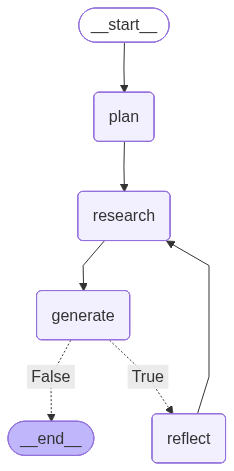

In [ ]:
from IPython.display import Image, display
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.types import interrupt, Command
from typing import TypedDict, Annotated, List
from langchain_community.tools.tavily_search import TavilySearchResults
import re
import ast
import json
import hashlib
import chromadb
from chromadb.config import Settings
from pprint import pprint
from IPython.display import HTML, display
import html as html_lib

# Utility function
def extract_dict_from_string(text: str) -> dict:
    """
    Extract and convert a dictionary from a string that may contain extra text.
    Tries JSON first, then falls back to ast.literal_eval.
    """
    # Strip markdown code fences if present
    cleaned = text.strip()

    if re.search(r'```json', cleaned):
      list_substr = cleaned.split("```json")
      cleaned = list_substr[1]
    if re.search(r'```', cleaned):
      list_substr = cleaned.split("```")
      cleaned = list_substr[0]

    cleaned = cleaned.strip()

    try:
        result = json.loads(cleaned)
        if isinstance(result, dict):
            return result
    except json.JSONDecodeError:
        pass

    print(f"❌ Failed to extract dict from response:\n{text[:200]}")
    return {}

# Build tool
search_tool = TavilySearchResults(max_results=5)

# Research Memory - abstracted storage for future migration to Supabase/pgvector
class ResearchMemory:
    """Abstracted research memory. ChromaDB now, Supabase/pgvector for production."""

    def __init__(self):
        self.client = CHROMA_DB_CLIENT

        # Collection for research results (shared across all users)
        self.research_collection = self.client.get_or_create_collection(
            name="essay_research",
            metadata={"description": "Cached research from Tavily searches"}
        )

        # Collection for user preferences (per user_id, built from feedback over time)
        self.preference_collection = self.client.get_or_create_collection(
            name="user_preferences",
            metadata={"description": "User essay preferences learned from feedback"}
        )

    # --- Research Memory ---
    def store_research(self, research_text: str, outline: str, revision: int):
        """Store research results for future retrieval. Shared across all users."""
        doc_id = hashlib.md5(research_text[:200].encode()).hexdigest()
        self.research_collection.upsert(
            documents=[research_text],
            metadatas=[{
                "outline_snippet": outline[:500],
                "revision": str(revision)
            }],
            ids=[doc_id]
        )
        print(f"  ✅ Stored research in memory (id: {doc_id[:8]}...)")

    def retrieve_research(self, query: str, n_results: int = 3) -> str:
        """Retrieve existing research relevant to the query. Searches across all users."""
        if self.research_collection.count() == 0:
            print(f"  ℹ️  Research memory is empty")
            return ""
        results = self.research_collection.query(
            query_texts=[query],
            n_results=n_results
        )
        if results['documents'] and results['documents'][0]:
            print(f"  ✅ Found {len(results['documents'][0])} existing research entries")
            return "\n---\n".join(results['documents'][0])
        print(f"  ℹ️  No relevant research found in memory")
        return ""

    def clear_research(self):
        """Clear research for a fresh essay topic."""
        self.client.delete_collection("essay_research")
        self.research_collection = self.client.get_or_create_collection(name="essay_research")
        print(f"  ✅ Research memory cleared")

    # --- User Preference Memory ---
    def store_feedback(self, user_id: str, requirement: str, feedback: str, score: int):
        """Store user feedback to learn preferences over time."""
        doc_id = hashlib.md5(f"{user_id}_{requirement[:100]}_{score}".encode()).hexdigest()
        self.preference_collection.upsert(
            documents=[f"Requirement: {requirement}\nFeedback: {feedback}\nScore: {score}"],
            metadatas=[{
                "user_id": user_id,
                "score": str(score),
                "requirement_snippet": requirement[:500]
            }],
            ids=[doc_id]
        )
        print(f"  ✅ Stored user feedback for preference learning")

    def retrieve_preferences(self, user_id: str, topic: str, n_results: int = 3) -> str:
        """Retrieve past feedback for a user to personalize future essays."""
        if self.preference_collection.count() == 0:
            return ""
        results = self.preference_collection.query(
            query_texts=[topic],
            n_results=n_results,
            where={"user_id": user_id}
        )
        if results['documents'] and results['documents'][0]:
            print(f"  ✅ Found {len(results['documents'][0])} past preference entries for user '{user_id}'")
            return "\n---\n".join(results['documents'][0])
        return ""

# Setup prompt for each task
PROMPT_PLAN = """
  You are an expert essay planner. Your job is to create a detailed and well-structured outline for an essay that will be no longer than 5 paragraphs

  Given the topic and requirements from the user, you must produce an outline that includes:
  1. A strong thesis statement
  2. An introduction section with a hook and context
  3. 3-5 main body sections, each with:
    - A clear section title
    - 2-3 key points to cover
    - A brief description of what each point should address
  4. A conclusion section that ties everything together

  Guidelines:
  - The outline should be logical and flow naturally from one section to the next
  - Each section should build upon the previous one
  - Make sure the outline directly addresses the user's requirements
  - Tailor the depth and complexity to match the required essay length and academic level

  User Input:
  {user_input}

  Agent Output in JSON Format where "" represent the keys :
  - "requirement", derrived from user input
  - "outline", the outline produced by the agent based on the prompt
  - "max_revisions", the maximum revision of the draft essay based on the user input, if it's not specified by the user return 0
  - "max_web_search", the maximum web search that can be done by the agent based on the user input, if it's not specified by the user return 0
"""

PROMPT_RESEARCH = """
  You are an expert research assistant. Your job is to gather relevant information and sources to support an essay based on a given outline.
  If the feedback is not empty, focus on doing search to help gain information to assess the feedback
  You can do up to {max_web_search} searches.

  **Existing Research from Previous Iterations:**
  The following research has already been gathered. Use this as context — you may skip topics
  already well-covered and focus your search quota on gaps or feedback-driven areas.
  You are free to use your full search quota if you believe the existing research is insufficient.
  If the existing research is empty, proceed with full research.

  Existing Research:
  {existing_research}

  For each section and key point in the outline, you must:
  1. Review the existing research above to see what's already covered
  2. Search the web for points that need new or better sources
  3. Extract key facts, statistics, quotes, or arguments that support the point
  4. Note the source URL and title for citation purposes
  5. Prioritize recent and authoritative sources (academic journals, reputable news, official reports)

  Guidelines:
  - Search for each main section and key point separately to ensure thorough coverage
  - If a search does not return useful results, try rephrasing the query
  - Avoid using low-quality or unreliable sources (forums, opinion blogs without credentials)
  - Collect at least 2-3 supporting pieces of information per key point
  - Organize the collected information according to the outline structure

  Essay Outline:
  {outline}

  Feedback:
  {feedback}

  Agent Output in JSON Format where "" represent the keys :
  - "research", that containsFor each section in the outline, provide with this format
    - Section title
    - Key Point
      - Supporting fact/quote/argument
      - Source: [title] (URL)
"""

PROMPT_GENERATE = """
  You are an expert essay writer. Your job is to write a well-structured, coherent, and polished essay based on the provided outline and research materials.

  Guidelines:
  - Follow the outline structure closely
  - Integrate the research findings naturally into the essay — do not simply list facts
  - Write in a clear, engaging, and appropriate academic tone
  - Each paragraph should have a clear topic sentence and flow logically
  - Use transitions between sections to maintain coherence
  - Support claims with evidence from the research materials
  - Include proper in-text citations where relevant (e.g., "According to [Source], ...")
  - Match the tone and complexity to the user's original requirements
  - Do NOT make up facts or statistics that are not in the provided research

  Essay Outline:
  {outline}

  Research Materials:
  {research}

  User Requirements:
  {requirement}

  **User Writing Preferences (from past sessions):**
  The following are past feedback and preferences from this user. Use them to tailor
  the essay's tone, depth, and style to what this user prefers.
  If empty, use standard academic tone.

  {user_preferences}

  Agent Output in JSON Format where "" represent the keys :
  - "essay", Write the full essay from introduction to conclusion.
"""

PROMPT_REFLECT = """
You are an expert essay editor and evaluator. Your job is to critically evaluate an essay and provide detailed, constructive feedback.

Evaluate the essay based on the following criteria:
1. Structure & Organization
   - Does the essay follow a logical flow?
   - Are transitions between sections smooth?
   - Is the outline structure well executed?

2. Thesis & Argumentation
   - Is the thesis clear and strong?
   - Does the essay consistently support the thesis?
   - Are arguments well-developed and convincing?

3. Evidence & Support
   - Is the essay well-supported with evidence?
   - Are sources credible and properly referenced?
   - Are facts and statistics used effectively?

4. Writing Quality
   - Is the tone appropriate and consistent?
   - Is the writing clear and concise?
   - Are there any grammatical or spelling errors?

5. Alignment with Requirements
   - Does the essay meet all of the user's original requirements?
   - Is the length and depth appropriate?
   - Is the target audience addressed correctly?

Essay to Evaluate:
{essay}

User's Original Requirements:
{requirement}

Agent Output in JSON Format where "" represent the keys :
- "score", give the rating from the scale of 0-10, integer only
- "feedback", the detailed evaluation along with the revision priorities
- "need_to_revised", based on the assessment of the agent return only yes/no where yes mean the draft need to be revised, make sure that it's aligned with the 'score'
"""

PROMPT_HTML = """
  Please help change this text to HTML mode, highlight the key point from the text with bold and red pastel color
  Strictly simply used the content of the text, don't add the content, but make the HTML professional with white background

  Text : {text}
"""

# Agent state
class AgentState(TypedDict):
    task: str
    user_id: str
    requirement: str
    outline: str
    research: str
    essay: str
    feedback: str
    score: int
    need_to_revised: str
    content: List[str]
    revision_number: int

    # user input
    max_revisions: int
    max_web_search: int

# Build model with LangGraph
class EssayWriterAgent:
    def __init__(self, tools, middleware, max_revision:int = 3):
        self.config = {'configurable': {'thread_id': 101}}
        self.max_revision = max_revision
        self.checkpointer = InMemorySaver()
        self.research_memory = ResearchMemory()

        # Store tools as dictionary
        self.tools = {t.name: t for t in tools}

        # create LLM with tool binding
        self.llm = init_chat_model(
            model="claude-haiku-4-5-20251001",
            temperature=0.5,
        )

        # Bind tools to the model
        self.llm_with_tools = self.llm.bind_tools(tools)

        # to initiate the Graph
        self.graph = StateGraph(AgentState)
        self.graph.add_node('plan', self.call_agent_plan)
        self.graph.add_node('research', self.call_agent_research)
        self.graph.add_edge('plan', 'research')
        self.graph.add_node('generate', self.call_agent_generate)
        self.graph.add_edge('research', 'generate')
        self.graph.add_conditional_edges(
            'generate',
            self.check_revision_iteration,
            {True: 'reflect', False: END})
        self.graph.add_node('reflect', self.call_agent_reflect)
        self.graph.add_edge('reflect', 'research')
        self.graph.set_entry_point('plan')

        self.graph_np = self.graph.compile(
            checkpointer=self.checkpointer,
            )

    def _update_state(self, new_dict:dict, state: AgentState):
      """Check whether the state will be updated based on the JSON output from the LLM response """
      for key, value in new_dict.items():
        if key in state:
          print(f"  ✅ Updated '{key}'")
        else:
          print(f"  ⚠️  Unknown key '{key}' - skipped")

    def _print_html_process(self, text:str):
      """Make the result to be in HTML format and print it"""
    
      message_html = HumanMessage(content = PROMPT_HTML.format(
            text=text,
          )
        )
      final_answer_html = self.llm.invoke([message_html])

      escaped = html_lib.escape(final_answer_html.content)

      display(HTML(f"""
        <iframe srcdoc="{escaped}" style="width:100%; height:600px; border:none; border-radius:8px;" sandbox="allow-same-origin"></iframe>
      """))     

    def _invoke_agent(self, human_message, answer_type:str = 'invoke'):
      """Get the LLM output and add to state"""
      print(f"  ✅ Added HumanMessage to state content")

      # If it's invoke
      if answer_type == 'invoke':

        result = self.llm.invoke([human_message])

        print(f"  ✅ Added Last AIMessage to state content")

        return result

      # If it's stream
      elif answer_type == 'stream':

        messages = [human_message]

        while True:
          response = self.llm_with_tools.invoke(messages)
          messages.append(response)

          # If no tool calls, LLM is done
          if not response.tool_calls:
            pprint(messages[-1])
            print(f"  ✅ Added Last AIMessage to state content")

            return messages[-1]

          # Execute tool calls
          for tc in response.tool_calls:
            print(f"  🔧 Calling tool: {tc['name']}")
            print(f"     Args: {tc['args']}")

            result = self.tools[tc['name']].invoke(tc['args'])

            result_str = str(result)
            for i, item in enumerate(ast.literal_eval(result_str)):
              print(f"\n    {'='*40}")
              print(f"    Item {i}")
              print(f"    {'='*40}")
              print(f"    {json.dumps(item, indent=2, default=str)}")

            messages.append(ToolMessage(
                tool_call_id=tc['id'],
                name=tc['name'],
                content=str(result)
            ))

    def call_agent_plan(self, state: AgentState):
      """Function to call agent with the promt to produce the outline of the essay"""
      # Invoke LLM
      message = HumanMessage(content = PROMPT_PLAN.format(
          user_input=state['task']
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING OUTLINE")
      print(f"{'='*60}")

      result = self._invoke_agent(message)
      json_result = extract_dict_from_string(result.content)
      self._update_state(json_result, state)

      print(f"\n=== ✅ Requirement ===")
      self._print_html_process(json_result.get('requirement', ''))
      print(f"\n=== ✅ Outline ===")
      self._print_html_process(json_result.get('outline', ''))

      return {
        'outline': json_result.get('outline', ''),
        'requirement': json_result.get('requirement', ''),
        'max_revisions': state['max_revisions'] if json_result.get('max_revisions', 1) == 0 else json_result.get('max_revisions', 1),
        'max_web_search': state['max_web_search'] if json_result.get('max_web_search', 3) == 0 else json_result.get('max_web_search', 3),
        'content': state['content'] + [message, result]
      }

    def call_agent_research(self, state: AgentState):
      """Function to call agent with the prompt to produce the resource to make the essay"""

      # Retrieve existing research from memory
      query = f"{state['outline'][:500]}\n{state['feedback'][:500]}"
      existing_research = self.research_memory.retrieve_research(query)

      # Invoke LLM
      message = HumanMessage(content = PROMPT_RESEARCH.format(
          outline=state['outline'],
          feedback=state['feedback'],
          max_web_search=state['max_web_search'],
          existing_research=existing_research if existing_research else "(none yet)"
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING RESEARCH")
      print(f"{'='*60}")

      result = self._invoke_agent(message, 'stream')
      json_result = extract_dict_from_string(result.content)
      self._update_state(json_result, state)

      print(f"\n=== ✅ Research ===")
      self._print_html_process(json_result.get('research', ''))

      # Store new research to memory
      new_research = json_result.get('research', '')
      if new_research:
          self.research_memory.store_research(
              str(new_research), state['outline'],
              state['revision_number']
          )

      return {
        'research': json_result.get('research', ''),
        'content': state['content'] + [message, result]
      }

    def call_agent_generate(self, state: AgentState):
      """Function to call agent with the prompt to produce the draft for the essay"""

      # Retrieve user preferences from past feedback
      user_preferences = self.research_memory.retrieve_preferences(
          state['user_id'], state['task']
      )

      # Invoke LLM
      message = HumanMessage(content = PROMPT_GENERATE.format(
          outline=state['outline'],
          research=state['research'],
          requirement=state['requirement'],
          user_preferences=user_preferences if user_preferences else "(no past preferences)"
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING DRAFT - ITERATION {state['revision_number'] + 1}")
      print(f"{'='*60}")

      result = self._invoke_agent(message)
      json_result = extract_dict_from_string(result.content)
      self._update_state(json_result, state)

      print(f"\n=== ✅ Essay ===")
      self._print_html_process(json_result.get('essay', ''))

      return {
        'essay': json_result.get('essay', ''),
        'content': state['content'] + [message, result]
      }

    def check_revision_iteration(self, state: AgentState):
      """Function to decide whether the draft need to be assess by Reflect agent"""

      print(f"\n{'='*60}")
      print(f"DETERMINE DRAFT NEED TO BE ASSESSED ?")
      print(f"{'='*60}")

      # # Draft will always be assessed if it's in the 1st iteration
      if state['revision_number'] < state['max_revisions']:
        return True
      else:
        if state['need_to_revised'] == 'yes' :
          revised_input = input(f"\n⏸️  Reflect agent say it's need to be revised (Score : {state['score']}), would you want to proceed with revision ? (yes/no)").strip().lower()
        elif state['need_to_revised'] != 'yes' :
          revised_input = input(f"\n⏸️  Reflect agent say the draft is already good 👍 (Score : {state['score']}), would you want to proceed with revision ? (yes/no)").strip().lower()

        if revised_input == 'yes' :
          return True
        else :
          return False

    def call_agent_reflect(self, state: AgentState):
      """Function to call agent with the prompt to evaluate the essay draft"""

      # Invoke LLM
      message = HumanMessage(content = PROMPT_REFLECT.format(
          essay=state['essay'],
          requirement=state['requirement'],
        )
      )

      print(f"\n{'='*60}")
      print(f"ASSESSING DRAFT - ITERATION {state['revision_number'] + 1}")
      print(f"{'='*60}")

      result = self._invoke_agent(message)
      json_result = extract_dict_from_string(result.content)
      self._update_state(json_result, state)

      print(f"\n=== ✅ Feedback ===")
      print(f"Draft Score : {json_result.get('score', 0)}")
      self._print_html_process(json_result.get('feedback', ''))

      # Store feedback as user preference (persists across sessions)
      self.research_memory.store_feedback(
          state['user_id'],
          state['requirement'],
          json_result.get('feedback', ''),
          json_result.get('score', 0)
      )

      return {
        'feedback': json_result.get('feedback', ''),
        'score': json_result.get('score', 0),
        'need_to_revised': json_result.get('need_to_revised', 'yes'),
        'revision_number': state['revision_number'] + 1,
      }

    def execute(self, message, user_id: str = "default") :
      """Function to run the agent graph flow"""

      self.input_message = message

      # Clear research cache for new topic, but KEEP preferences (cross-session)
      # self.research_memory.clear_research()

      print(f"\n{'='*60}")
      print(f"TOPIC FROM THE USER")
      print(f"{'='*60}")
      self._print_html_process(self.input_message)

      # ✅ Initialize ALL required state fields
      initial_state = {
          'task': self.input_message,
          'user_id': user_id,
          'requirement': '',
          'outline': '',
          'research': '',
          'essay': '',
          'feedback': '',
          'need_to_revised' : 'yes',
          'score': 0,
          'content': [],
          'revision_number': 0,
          'max_revisions': self.max_revision,
          'max_web_search': 3,
      }

      # Run the graph
      result = self.graph_np.invoke(
          initial_state,
          config=self.config
      )

      # Get final answer
      final_answer = result['essay']

      # Change it to HTML mode
      print(f"\n{'='*60}")
      print(f"CHANGE THE ESSAY TO HTML MODE")
      print(f"{'='*60}")

      message_html = HumanMessage(content = PROMPT_HTML.format(
          text=final_answer,
        )
      )
      final_answer_html = self._invoke_agent(message_html)

      print(f"\n ✅ HTML Generated")

      return final_answer_html


# Define system prompt
bot = EssayWriterAgent([search_tool], [], 3)

# Display LangGraph structure
try:
    # Try to visualize the graph
    display(Image(bot.graph_np.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")
    print("\nGraph structure (ASCII):")
    print(bot.graph_np.get_graph().draw_ascii())

In [5]:
html = bot.execute("""
    Make me an essay about the thing's discussed in thins linkedin post https://www.linkedin.com/posts/activity-7430165848746614784-qrSO?utm_source=share&utm_medium=member_desktop&rcm=ACoAACMcvqkBIzfqjaPJhbXtUzkIg2WDtIH4i0Q
    Search for other relevant source, I want to know the latest research on this part "in favor of duration-indexed causal effects, quantile treatment effects, and distributional methods built for heavy-tailed setting"
    you can do 5 web search and 1 revision
    """
    , user_id="cello"
)

  ✅ Research memory cleared

TOPIC FROM THE USER
('\n'
 "    Make me an essay about the thing's discussed in thins linkedin post "
 'https://www.linkedin.com/posts/activity-7430165848746614784-qrSO?utm_source=share&utm_medium=member_desktop&rcm=ACoAACMcvqkBIzfqjaPJhbXtUzkIg2WDtIH4i0Q\n'
 '    Search for other relevant source, I want to know the latest research on '
 'this part "in favor of duration-indexed causal effects, quantile treatment '
 'effects, and distributional methods built for heavy-tailed setting"\n'
 '    you can do 5 web search and 1 revision\n'
 '    ')

GENERATING OUTLINE
  ✅ Added HumanMessage to state content
  ✅ Added Last AIMessage to state content
  ✅ Updated 'requirement'
  ✅ Updated 'outline'
  ✅ Updated 'max_web_search'
  ✅ Updated 'max_revisions'

=== ✅ Requirement ===
('Create a 5-paragraph essay about advanced causal inference methods, '
 'specifically focusing on: (1) duration-indexed causal effects, (2) quantile '
 'treatment effects, and (3) distribution

KeyError: slice(None, 500, None)

In [9]:
from IPython.display import HTML, display
import html as html_lib

escaped = html_lib.escape(html.content)

display(HTML(f"""
<iframe srcdoc="{escaped}" style="width:100%; height:600px; border:none; border-radius:8px;" sandbox="allow-same-origin"></iframe>
"""))